# Unsupervised Computer vision based Anomaly Detection
#### - GAN(Generative Adversal Network)을 이용한 이상감지

본 노트북은 GAN(Generative Adversal Network)을 이용하여 이미지 데이터에 이상감지를 적용하는 방법을 보여줍니다. 구현원리와 아이디어는 다음 링크의 논문(https://arxiv.org/abs/1703.05921)으로부터 직접 참조할 수 있습니다. 본 예제는 해당 아이디어를 Tensorflow Keras와 SageMaker를 이용하여 MNIST 데이터셋에 이상감지를 적용해 볼 것입니다. GAN네트워크는 다음 링크(https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py)의 DC GAN을 참고하였습니다. AnoGAN 구현코드는 다음링크(https://github.com/yjucho1/anoGAN)를 참고하였습니다.

구현단계를 간단히 요약하면 다음과 같습니다.

#### Step 1) 정상 이미지를 이용하여 Generative 모델을 생성한다. 
정상 이미지를 이용하여 이와 유사한 이미지를 만들 수 있는 Generative 모델을 정의하고 학습합니다. 본 예제에서는 28x28 grayscale의 이미지를 생성하는 GAN Network을 정의하고 MNIST 이미지와 유사한 이미지를 생성하도록 Network를 학습시킵니다.

![](images/gan.png)

#### Step 2) Generative 모델에서 사용할 latent vector를 추론하는 모델을 생성한다. 
Step 1의 GAN을 이용하여 이상감지 모델을 생성합니다. 학습된 GAN이 정상 데이터와 유사한 이미지는 잘 생성하지만 학습단계에서 보지 못한 이상 데이터와 유사한 데이터는 잘 생성하지 못하는 특징을 활용하여 Anomaly Score를 정량적으로 구합니다.

![](images/anogan1.png)

본 예제를 실행하면서 단계별로 그 과정과 설명을 확인할 수 있습니다.

---
# STEP 1. DCGAN Training
---
## 1. import libraries and data

먼저 필요한 라이브러리들을 로드합니다.

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(X_train, y_train), (_, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


<br>
잘 알려진 MNIST 데이터셋을 활용힐 것입니다. MNIST는 손글씨 숫자로 이루어진 28x28 이미지데이터입니다.

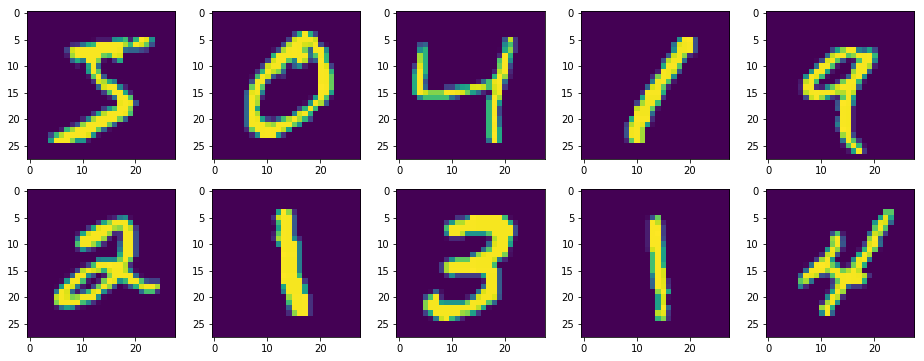

In [3]:
# plt.imshow(X_train[100].reshape(28,28))
plt.figure(figsize=(16,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i])
plt.show()

---
## 2. DCGAN 네트워크 정의

Anomaly Detection에서 사용할 이미지 생성모델이 필요합니다. 다음 코드를 통해 DC GAN을 정의합니다.

#### 2-1. Generator 생성함수
`input_dim` 파라미터를 통해 임의의 사이즈(본 예제에서는 100 사용)와 채널(본 예제는 grayscale이므로 1사용)를 가지는 latent_dim 벡터를 입력받아  UpSampling과 Convolutional Network을 이용하여 28x28 image를 Generate하는 신경망입니다.

In [26]:
def build_generator(latent_dim, channels):

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    
    return model

# 테스트
build_generator(100, 1).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 28, 28, 128)       0         
__________

#### 2-2. Discriminator 생성함수
28x28 이미즈를 입력받아 Convolution 연산을 실행하여 feature vector를 생성하고 binary classification을 위한 하나의 노드를 출력하는 신경망입니다.

In [29]:
def build_discriminator(img_shape):

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

#테스트
build_discriminator((28,28,1)).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

#### 2-3. DC GAN 네트워크 생성

Generator와 Discriminator를 조합하여 GAN 네트워크를 생성합니다. 

In [78]:
def get_dcgan(img_rows=28, img_cols=28, channels=1, latent_dim=100, lr=0.0002, beta_1=0.5):

    img_shape = (img_rows, img_cols, channels)
    optimizer = Adam(lr, beta_1)

    # Build and compile the discriminator
    discriminator = build_discriminator(img_shape)
    discriminator.compile(loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

    # Build the generator
    generator = build_generator(latent_dim, channels)

    # The generator takes noise as input and generates imgs
    z = Input(shape=(latent_dim,))
    img = generator(z)

    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    validity = discriminator(img)

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    combined = Model(z, validity)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    return generator, discriminator, combined

# 테스트
_, _, combined = get_dcgan()
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_20 (Sequential)   (None, 28, 28, 1)         856193    
_________________________________________________________________
sequential_19 (Sequential)   (None, 1)                 393729    
Total params: 1,249,922
Trainable params: 855,809
Non-trainable params: 394,113
_________________________________________________________________


#### 2-4. 유틸리티 함수 정의


##### 이미지 feed 함수
학습용 데이터를 feed하는 함수를 정의합니다. 본 예제는 minist로부터 데이터를 로드하고 있지만, 실제 업무 적용시 스토리지로부터 이미지를 읽고 numpy.arary 등 학습에서 요구되는 포맷으로 변환하는 내용이 구현될 것입니다.

In [79]:
def feed_imgs():
    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
    
    return X_train

# 테스트
feed_imgs().shape

(60000, 28, 28, 1)

##### 이미지 저장함수
Generator 를 통해 생성된 이미지를 저장하는 함수를 정의합니다. 학습진행에 따른 Generator의 성능 확인을 위해 사용할 것입니다.

In [31]:
!mkdir gen_images

In [84]:
def save_imgs(epoch, latent_dim, generator, path='gen_images'):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("{}/mnist_{}.png".format(path, epoch))
    plt.close()

##### Model weight 저장함수

Generator와 Discriminator의 네트워크 Weight값을 저장합니다.

In [87]:
!mkdir model

In [88]:
def save_models(epoch, discriminator, generator, path='model'):
    discriminator.save_weights('{}/d-{}.ckpt'.format(path,epoch))
    generator.save_weights('{}/g-{}.ckpt'.format(path,epoch))
    

#### 2-5. GAN Training test

정의한 GAN 네트워크가 학습이 잘 되는지 확인합니다. 디버깅이 목적이므로 epochs은 5번만 반복합니다.

In [136]:
def train_dcgan(epochs=5, bach_size=32, latent_dim=100, lr=0.0002, beta_1=0.5, 
                log_interval=100, save_interval=100, gen_image_path='gen_images', model_path='model') :
    
    X_train = feed_imgs()
    
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    # DCGAN Network definition
    generator, discriminator, combined = get_dcgan(lr=lr, beta_1=beta_1, latent_dim=latent_dim)

    d_losses = []
    g_losses = []
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Select a random half of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)

        # ---------------------
        #  Training logs
        # ---------------------
        d_losses.append(d_loss)
        g_losses.append(g_loss)

        # Plot the progress
        if epoch % log_interval == 0:
            print ("%5d [D loss: %f, acc.: %.2f%%] [G loss: %f] [d+g: %f] [d+2g: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss, (d_loss[0]+g_loss)/2, (d_loss[0]+2*g_loss)/3))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch, latent_dim, generator, gen_image_path)
        
    # save weights
    save_models(epoch, discriminator, generator, model_path)
    
    return d_losses, g_losses

In [98]:
%%time
d_losses, g_losses = train_dcgan(log_interval=1, save_interval=1)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


    0 [D loss: 1.175357, acc.: 32.81%] [G loss: 0.564914] [d+g: 0.870135] [d+2g: 0.768395]


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


    1 [D loss: 0.823112, acc.: 53.12%] [G loss: 0.641118] [d+g: 0.732115] [d+2g: 0.701783]
    2 [D loss: 0.771770, acc.: 60.94%] [G loss: 1.015440] [d+g: 0.893605] [d+2g: 0.934216]
    3 [D loss: 0.581820, acc.: 70.31%] [G loss: 1.093943] [d+g: 0.837881] [d+2g: 0.923235]
    4 [D loss: 0.370611, acc.: 85.94%] [G loss: 1.103990] [d+g: 0.737301] [d+2g: 0.859530]
CPU times: user 39.5 s, sys: 157 ms, total: 39.7 s
Wall time: 39.6 s


discriminator의 loss, accuracy와 generator의 loss가 리턴되었다. GAN의 정의에 따라 두 네트워크가 번갈아 가며 학습될 것이다.

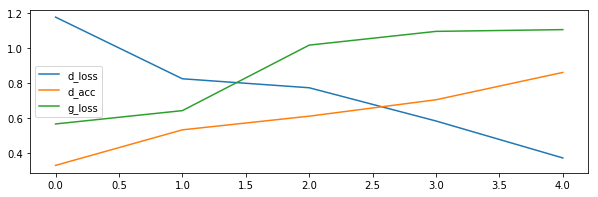

In [118]:
plt.figure(figsize=(10,3))
plt.plot(d_losses)
plt.plot(g_losses)
plt.legend(['d_loss', 'd_acc', 'g_loss'])
plt.show()

---
## 3. DCGAN SageMaker Training

GAN 네트워크의 디버깅이 완료되었으므로 이제 클라우드의 GPU 자원을 이용하여 학습을 실행하겠습니다. GPU 인스턴스 사용을 위해 aws에서 제공하는 머신러닝 서비스(플랫폼)인 SageMaker API를 이용합니다. SageMaker를 이용하면 학습하는 동안에만 GPU 인스턴스를 할당받고 학습완료 후 자원을 바로 반납하도록 구성할 수 있습니다. 해당 작업을 위해 앞서 테스트한 코드를 일부 변경하겠습니다. 이후 변경된 코드를 통해 반복하여 학습을 실행하며 해당 실험을 진행하는 동안 SageMaker로부터 자원을 임대하는 구조를 계속해서 가져갈 수 있습니다.


#### 3-1. Training script 작성

앞서 테스트한 코드를 변경하여 SageMaker Tensorflow Docker에서 학습을 실행할 수 있도록 별도 파일로 저장합니다. 해당 파일은 SageMaker를 통한 작업 실행시 entry_point라는 파라미터를 통해 컨테이너 내부로 copy될 것입니다. 해당 코드는 신경망 학습이 컨테이너 내부에서 실행될 수 있도록 다음 세 부분이 추가로 수정되었습니다. 코드와 함께 아래 내용을 확인합니다.


#### entry point script 작성시 확인사항

1. **입력(학습) 데이터 경로** - S3에 업로드된 학습데이터는 도커 컨테이너 내부의 `/opt/ml/input/data/{채널명}` 경로에 복제되므로 해당 위치에서 학습데이터를 읽어야 합니다. 여기서 채널명은 이후 셀에서 학습 실행(`fit`) 단계에 패스하게 되는 'train', 'test', 'validation' 등과 같은 구분값입니다. 해당 값은 도커 실행시 SM_CHANNEL_TRAIN 이라는 환경변수에 저장되어 있습니다. 본 예제에서는 해당 환경변수를 `args.train argument`를 통해 할당한 후 `get_train_data()` 함수 호출시 파라미터로 전달하는 구조를 사용하고 있습니다. (main함수 시작 부분의 코드를 참고하세요)

2. **출력(모델) 데이터 경로** - 학습이 완료되면 학습 리소스는 반납되므로, 학습결과로 생성된 모델은 다른 경로에 저장해 두어야 합니다. SageMaker에서는 도커 컨테이너 내부에서 `/opt/ml/model/`경로에 저장된 모델 파일을 S3로 export합니다. 또 학습 산출물을 export하기 위한 `/opt/ml/output/`경로의 파일들도 S3로 export 됩니다. (NLP 문제일 경우 voacabulary, 생성이미지, 그래프, 별도 로그 등 작업에 따라 다양한 결과물을 처리할 수 있음.) 본 예제에서는 `SM_MODEL_DIR` 환경변수를 이용하여 main함수의 맨아래 줄에서 해당 경로에 모델을 저장하고 있습니다.

3. **하이퍼파라미터 argument** - 학습실행을 요청하는 노트북환경에서 하이퍼파리미터 등을 제어할 경우에도 마찬가지 방식으로 command-line argument를 이용합니다. `Estimator` 선언시 Hyperparamenter로 지정한 값들은 entry point 스크립트 실행시 사용자 정의 argument의 형태로 전달됩니다. 위 코드에서 (앞 단계 Estimator 지정시 선언한 하이퍼파라미터인) `epoch`, `batch_size`, `learning_rate`을 parsing하는 부분을 확인합니다.


#### 추가 참고사항
SageMaker Tensorflow 컨테이너에서 실행되는 entry_point 스크립트 작성에 대한 보다 자세한 내용은 다음 SDK 문서를 참고하십시오.  
https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#train-a-model-with-tensorflow

또는 다음 예제를 통해 작성방법을 실습해 보십시오.  
https://github.com/mullue/sm-tf2/blob/master/tf-2-workflow.ipynb



In [120]:
!mkdir src

In [212]:
%%writefile src/dcgan.py

# 필요한 라이브러리를 로드합니다.
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
import sys
import numpy as np
import os
import argparse
# import math

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# 컨테이너에서 기본으로 제공하지 않는 라이브러리를 추가로 설치 & import 합니다.
os.system('pip install -r requirements.txt')
import matplotlib.pyplot as plt


# 컨테이너 외부에서 Hyperparameter와 Input/Output늘 제어하는 부분이 추가되었습니다.
def parse_args():
    
    parser = argparse.ArgumentParser()
                                
    # hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--lr', type=float, default=0.000000005)
    parser.add_argument('--beta_1', type=float, default=0.9)
    parser.add_argument('--latent_dim', type=int, default=100)
    parser.add_argument('--log_interval', type=int, default=10)
    parser.add_argument('--save_interval', type=int, default=50)
    # data directories
#     parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))
    parser.add_argument('--gen_image_path', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--model_path', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))

    return parser.parse_known_args()

# 노트북에서 테스트한 generator 함수와 동일합니다.
def build_generator(latent_dim, channels):

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    
    return model

# 노트북에서 테스트한 discriminator 함수와 동일합니다.
def build_discriminator(img_shape):

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# 노트북에서 테스트한 DCGAN 함수와 동일합니다.
def get_dcgan(img_rows=28, img_cols=28, channels=1, latent_dim=100, lr=0.0002, beta_1=0.5):

    img_shape = (img_rows, img_cols, channels)
    optimizer = Adam(lr, beta_1)

    # Build and compile the discriminator
    discriminator = build_discriminator(img_shape)
    discriminator.compile(loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

    # Build the generator
    generator = build_generator(latent_dim, channels)

    # The generator takes noise as input and generates imgs
    z = Input(shape=(latent_dim,))
    img = generator(z)

    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    validity = discriminator(img)

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    combined = Model(z, validity)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    return generator, discriminator, combined

# 노트북에서 사용한 이미지 feed함수와 동일합니다.
def feed_imgs():
    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
    
    return X_train

# 노트북에서 사용한 이미지 저장함수와 동일합니다.
def save_imgs(epoch, latent_dim, generator, path='gen_images'):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("{}/mnist_{}.png".format(path, epoch))
    plt.close()

# 노트북에서 사용한 모델 저장함수와 동일합니다.
def save_models(epoch, discriminator, generator, path='model'):
    discriminator.save_weights('{}/d-{}.ckpt'.format(path,epoch))
    generator.save_weights('{}/g-{}.ckpt'.format(path,epoch))
    
    
# 노트북에서 사용한 training 함수와 동일합니다.
def train_dcgan(epochs=5, bach_size=32, latent_dim=100, lr=0.0002, beta_1=0.5, 
                log_interval=100, save_interval=100, gen_image_path='gen_images', model_path='model') :
    
    X_train = feed_imgs()
    
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    # DCGAN Network definition
    generator, discriminator, combined = get_dcgan(lr=lr, beta_1=beta_1, latent_dim=latent_dim)

    d_losses = []
    g_losses = []
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Select a random half of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)

        # ---------------------
        #  Training logs
        # ---------------------
        d_losses.append(d_loss)
        g_losses.append(g_loss)

        # Plot the progress
        if epoch % log_interval == 0:
            print ("%5d [D loss: %f, acc.: %.2f%%] [G loss: %f] [d+g: %f] [d+2g: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss, (d_loss[0]+g_loss)/2, (d_loss[0]+2*g_loss)/3))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch, latent_dim, generator, gen_image_path)
        
    # save weights
    save_models(epoch, discriminator, generator, model_path)
    
    return d_losses, g_losses            

# SageMaker로부터 환경변수와 arugument를 통해 전달된 Hyperparameter 등 값을 parsing하여 training을 실행하도록 구성되었습니다.
if __name__ == "__main__":
    
    args, _ = parse_args()
    device = '/gpu:0' 

    # job paramters
    print("== job parameters ======================================")
    batch_size = args.batch_size
    epochs = args.epochs
    latent_dim=args.latent_dim
    lr = args.lr
    beta_1=args.beta_1
    log_interval=args.log_interval
    save_interval=args.save_interval
#     img_path=args.train
    gen_image_path=args.gen_image_path
    model_path=args.model_path
    model_dir=args.model_dir

    print("========================================================")

    # training 실행
    d_losses, g_losses = train_dcgan(epochs=epochs, bach_size=batch_size, latent_dim=latent_dim, lr=lr, beta_1=beta_1, 
                                     log_interval=log_interval, save_interval=save_interval, 
                                     gen_image_path=gen_image_path, model_path=model_path) 

    # output 저장
    with open('/opt/ml/output/data/g_losses.txt', 'w') as f:
        for item in g_losses:
            f.write("%s\n" % item)
        

Overwriting src/dcgan.py


In [122]:
%%writefile src/requirements.txt
-i https://pypi.org/simple
matplotlib==3.1.1

Writing src/requirements.txt


#### 3-2. SageMaker local mode로 테스트하기

train_instance_type 을 'local'로 지정하고 실행하면 로컬환경에 Tensorflow 컨테이너를 생성하여 학습을 실행합니다. 이 방법으로 SageMaker local mode라고 부릅니다. 로컬모드 이용시 클라우드에서 실행하는 것 보다 빠르게 결과를 확인할 수 있습니다. 이 기능은 entry_point 코드를 디버깅할 때 유용합니다.

In [213]:
import sagemaker
from sagemaker.tensorflow import TensorFlow

train_instance_type = 'local'
model_dir = '/opt/ml/model'

hyperparameters = {'epochs': 5, 'batch_size': 64, 'lr': 0.0002, 'beta_1':0.5,
                   'log_interval':1, 'save_interval':1 ,
                   'gen_image_path':'/opt/ml/output/data', 'model_path':model_dir}

estimator = TensorFlow(source_dir='src',
                             entry_point='dcgan.py',
                             train_instance_type=train_instance_type,
                             model_dir=model_dir,
                             train_instance_count=1,
                             hyperparameters=hyperparameters,
                             role=sagemaker.get_execution_role(),
                             base_job_name='sm-tf-dcgan',
                             framework_version='1.13',
                             py_version='py3',
                             script_mode=True)

본 예제에서는 mnist 라이브러리로부터 파일을 가져오도록 설계되어 training 이미 입력채널은 별도로 사용하지 않습니다. 만약 S3에 저장된 이미지 파일 등을 학습용 이미지로 사용하는 경우 fit()함수의 매개변수로 전달하여야 합니다. 해당 방법은 https://github.com/mullue/sm-tf2/blob/master/tf-2-workflow.ipynb 등 다른 Tensorflow script mode 예제를 참조할 수 있습니다. 

In [159]:
%%time
estimator.fit()

Creating tmpj8m6jadm_algo-1-t542u_1 ... 
Attaching to tmpj8m6jadm_algo-1-t542u_12mdone
algo-1-t542u_1  | 2020-06-14 09:48:37,955 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-t542u_1  | 2020-06-14 09:48:37,963 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-t542u_1  | 2020-06-14 09:48:38,153 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-t542u_1  | 2020-06-14 09:48:38,174 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-t542u_1  | 2020-06-14 09:48:38,194 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-t542u_1  | 2020-06-14 09:48:38,209 sagemaker-containers INFO     Invoking user script
algo-1-t542u_1  | 
algo-1-t542u_1  | Training Env:
algo-1-t542u_1  | 
algo-1-t542u_1  | {
algo-1-t542u_1  |     "additional_framework_parameters": {},
algo-1-t542u_1  |     "channel_input_dirs": {},
algo-1-t542u_1

Failed to delete: /tmp/tmpj8m6jadm/algo-1-t542u Please remove it manually.


===== Job Complete =====
CPU times: user 546 ms, sys: 119 ms, total: 664 ms
Wall time: 25.3 s


#### 3-3. SageMaker Cloud에서 Training 작업 실행하기

코드가 준비되었고 디버깅이 완료되었으면 이제 클라우드로 작업을 제출합니다. local mode 실행설정으로부터 다음 내용을 수정하였습니다.
- train_instance_type : 'local' -> 'ml.p3.2xlarge' (NVidia V100 GPU가 탑재된 인스턴스로 정의합니다.)
- epochs : 5 -> 1000 
- log_interval : 1 -> 100
- save_interval : 1 -> 100

In [222]:
train_instance_type = 'ml.p3.2xlarge'
model_dir = '/opt/ml/model'

hyperparameters = {'epochs': 10000, 'batch_size': 64, 'lr': 0.0002, 'beta_1':0.5,
                   'log_interval':100, 'save_interval':100 ,
                   'gen_image_path':'/opt/ml/output/data', 'model_path':model_dir}

estimator = TensorFlow(source_dir='src',
                             entry_point='dcgan.py',
                             train_instance_type=train_instance_type,
                             model_dir=model_dir,
                             train_instance_count=1,
                             hyperparameters=hyperparameters,
                             role=sagemaker.get_execution_role(),
                             base_job_name='sm-tf-dcgan',
                             framework_version='1.13',
                             py_version='py3',
                             script_mode=True)

In [223]:
%%time
estimator.fit()

2020-06-14 10:50:23 Starting - Starting the training job...
2020-06-14 10:50:25 Starting - Launching requested ML instances......
2020-06-14 10:51:38 Starting - Preparing the instances for training......
2020-06-14 10:52:49 Downloading - Downloading input data
2020-06-14 10:52:49 Training - Downloading the training image.....2020-06-14 10:53:36,203 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-06-14 10:53:36,589 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {},
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "beta_1": 0.5,
        "batch_size": 64,
        "lr": 0.0002,
        "log_interval": 100,
        "model_path": "/opt/ml/model",
        "save_interval": 100,
        "gen_image_path": "/opt/ml/output/data",
        "m

---
## 4. 학습결과 확인

#### 4-1. Sagemaker Training job outfile 확인
학습과정에서 Generator가 저장한 파일을 이용하여 Generator의 성능을 확인합니다. entry_point의 스크립트를 실행할때 생성 이미지의 저장경로 파라미터(`gen_image_path`)를 컨테이너 내부의 /opt/ml/output/data/에 저장하도록 지정하였습다. 그리고 해당 폴더의 파일들은 아래 경로에 `output.tar.gz`으로 export되었을 것입니다.

In [224]:
outpath = estimator.output_path + estimator.latest_training_job.job_name
outpath

's3://sagemaker-us-east-1-308961792850/sm-tf-dcgan-2020-06-14-10-50-23-058'

In [225]:
!aws s3 ls {outpath}/output/

2020-06-14 10:58:40    4645919 model.tar.gz
2020-06-14 10:58:41    2454543 output.tar.gz


`output.tar.gz`파일을 로컬로 복사해 온 후 압축을 풉니다. epoch별로 생성한 이미지를 확인할 수 있습니다. 클라우드에서 학습 실행시 `save_interval`을 100으로 지정하였으므로 100 epoch마다 파일이 생성되었을 것입니다.

In [226]:
!aws s3 cp {outpath}/output/output.tar.gz model_out/output.tar.gz
!tar -xvf model_out/output.tar.gz -C model_out

download: s3://sagemaker-us-east-1-308961792850/sm-tf-dcgan-2020-06-14-10-50-23-058/output/output.tar.gz to model_out/output.tar.gz


#### 4-2. 생성 이미지 확인

생성 이미지를 확인합니다. MNIST 데이터셋과 유사한 이미지를 생성하도록 학습되었습니다.

In [237]:
import matplotlib.image as mpimg

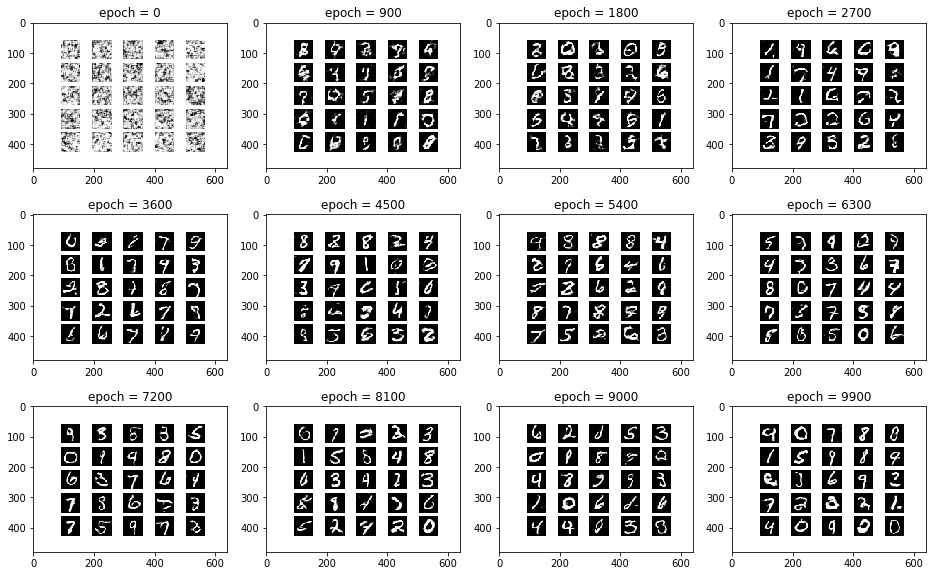

In [245]:
plt.figure(figsize=(16,10))
for i,epoch in zip(range(12), range(0,10000,900)):
    img = mpimg.imread('model_out/mnist_' + str(epoch) +'.png')
    plt.subplot(3,4,i+1)
    plt.title('epoch = ' + str(epoch))
    plt.imshow(img)
plt.show()

#### 4-3. 모델 Weight 추출

학습된 DCGAN Weight 파일은 동일 경로에 model.tar.gz파일로 export 되었습니다. 해당 파일은 다음의 이상감지 단계에서 활용할 것입니다. 학습된 Weight파일을 로컬로 가져옵니다. 

In [252]:
!aws s3 ls {outpath}/output/

2020-06-14 10:58:40    4645919 model.tar.gz
2020-06-14 10:58:41    2454543 output.tar.gz


In [253]:
!aws s3 cp {outpath}/output/model.tar.gz model/model.tar.gz
!tar -xvf model/model.tar.gz -C model

download: s3://sagemaker-us-east-1-308961792850/sm-tf-dcgan-2020-06-14-10-50-23-058/output/model.tar.gz to model/model.tar.gz
d-9999.ckpt
g-9999.ckpt


---
# STEP 2. 이상감지
---
DCGAN 생성모델이 준비되었으므로 이제 이상감지 모델을 구현하는 단계로 넘어가겠습니다.

## 5. Anomalous data 

이상데이터는 EMNIST 데이터셋을 사용하겠습니다. EMNIST 데이터셋은 숫자가 아닌 문자이미지이며, 28x28의 grayscale의 형식은 NIST와 동일합니다.

In [248]:
!pip install emnist

You should consider upgrading via the 'pip install --upgrade pip' command.


In [249]:
from emnist import list_datasets
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [250]:
from emnist import extract_test_samples
images, labels = extract_test_samples('letters')
images.shape

(20800, 28, 28)

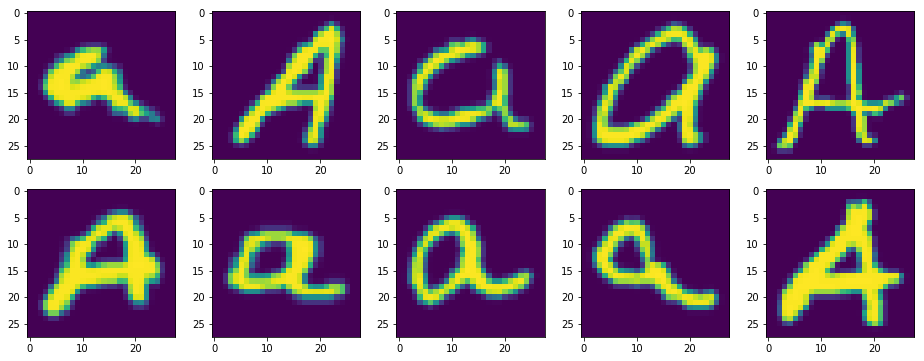

In [251]:
plt.figure(figsize=(16,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i])
plt.show()

---
## 6. AnoGAN 생성


AnoGAN 네트워크를 생성합니다. AnoGAN 네트워크의 정의와 학습은 다음 단계를 거칩니다.

![](images/anogan2.png)

- (1) size 100의 임의의 z를 입력받습니다.
- (2) 입력된 z는 Dense layer를 지나 generator에 입력하기 위한 latent vector를 생성합니다.
- (3) latent vector는 fix된 generator를 거쳐 임의의 이미지를 생성합니다. 
- (4) 3)의 결과를 입력으로 하여 fix된 Discriminnator를 거쳐 Real/Fake 판단을 위한 feature vector를 생성합니다.
- (5) normal/abnormal 판단을 위한 이미지를 이용하여 3), 4)에 대한 Ground truth 값을 생성합니다. (이미지 자체는 3)의 ground truth 역할을 하고, 해당 이미지로부터 Discriminator 연산을 통해 생성한 feature vector는 4)에 대한 ground truth가 됩니다.)
- (6) 생성된 (a), (b) 값을 ground truth와 비교하여 2)의 Dense layer를 학습합니다.
- (7) 학습과정에서 사용했던 데이터(정상데이터)일 수록 학습이 더 잘 될 것입니다. 이런 원리로 6) training 작업 loss 자체가 abnoaly score 역할을 할 수 있습니다.

AnoGAN 생성시 이전 단계에서 학습된 Generator와 Discriminator 네트워크와 Weight를 로드하여 사용합니다. 아래에서 호출하고 있는 build_discriminator()와 build_generator()는 앞서 DCGAN학습단계에서 생성한 동일한 함수입니다.

#### Discriminator로부터 feature를 도출하는 함수

In [258]:
def feature_extractor(img_shape):
    d = build_discriminator(img_shape)
    d.load_weights('model/d-9999.ckpt') 
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-6].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='adam')
    return intermidiate_model

#### AnnoGAN Netowrk
임의의 z로부터 latent vector를 생성하고 Generator와 앞서 feature_extractor를 호출합니다.

In [344]:
def gen_anogan(loss, latent_dim=100, channels=1, img_shape=(28,28,1)):
    g = build_generator(latent_dim, channels)
    g.load_weights('model/g-9999.ckpt')
    g.trainable = False
    intermidiate_model = feature_extractor(img_shape)
    intermidiate_model.trainable = False

    z = Input(shape=(100,))
    gInput = Dense((100))(z)
    G_out = g(gInput)
    D_out = intermidiate_model(G_out)    
    model = Model(inputs=z, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.9, 0.1], optimizer='adam')
    
    return model

In [345]:
def sum_of_residual(y_true, y_pred):
    return tf.reduce_sum(abs(y_true - y_pred))

In [346]:
model = gen_anogan(loss=sum_of_residual)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 100)               10100     
_________________________________________________________________
sequential_57 (Sequential)   (None, 28, 28, 1)         856193    
_________________________________________________________________
model_33 (Model)             (None, 4, 4, 256)         388608    
Total params: 1,254,901
Trainable params: 10,100
Non-trainable params: 1,244,801
_________________________________________________________________


## 7. 정상데이터 테스트

아래 데이터를 정상 이미지로 하여 테스트를 진행합니다.

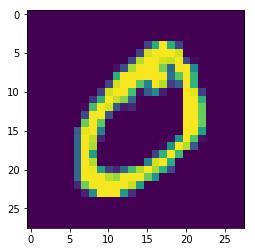

In [347]:
nimg = X_train[1].reshape(28,28)
plt.figure(figsize=(4,4))
plt.imshow(nimg)

In [348]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape)

# ground truth
x = nimg.reshape(1,28,28,1)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 30.3 s, sys: 19.7 ms, total: 30.4 s
Wall time: 29.2 s


학습을 통해 best latent vector를 추정한 후, 해당 latent vector를 이용하여 생성한 생성 이미지입니다. (500 epoch을 거쳐 원본과 유사한 결과를 생성할 수 있는 z를 찾았고 그 z를 이용하여 생성한 이미지입니다.) 원본 이미지와 유사한 이미지를 생성하고 있습니다.

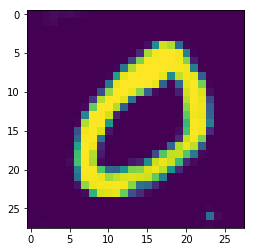

In [349]:
o1, o2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(o1.reshape(28,28))

loss 값을 확인해봅니다. 정의에 따라 이 loss값을 anomaly score로 바로 활용할 수 있습니다.

In [319]:
loss.history['loss'][-1]

386.406005859375

residual을 계산해 봅니다. 다음은 예측된 residual에 대한 시각적 표현입니다.

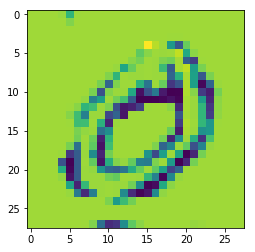

In [320]:
plt.figure(figsize=(4,4))
plt.imshow(X_train[1].reshape(28,28) - o1.reshape(28,28))

---
## 8. 이상데이터 테스트

EMNIST에서 임의의 데이터를 선정하여 abnomaly score가 정상에 비해 높게 나오는지 확인해 보겠습니다.

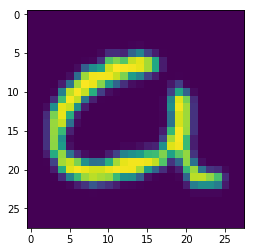

In [321]:
aimg = images[2].reshape(28,28)/ 127.5 - 1.
plt.figure(figsize=(4,4))
plt.imshow(aimg)

In [322]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape)

# ground truth
x = aimg.reshape(1, 28, 28, 1)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 19.8 s, sys: 59.4 ms, total: 19.9 s
Wall time: 18.8 s


학습을 통해 best latent vector를 추정한 후, 해당 latent vector를 이용하여 생성한 생성 이미지입니다. (500 epoch을 거쳐 원본과 유사한 결과를 생성할 수 있는 z를 찾았고 그 z를 이용하여 생성한 이미지입니다.) 정상 데이터에 비해 원본 이미지에 대한 재현률이 높지 않은 것을 시가적으로 확인할 수 있습니다. 

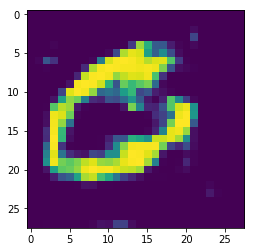

In [323]:
oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(oa1.reshape(28,28))

정상 데이터보다 큰 loss값을 확인할 수 있습니다.

In [327]:
loss_a.history['loss'][-1]

425.51104736328125

다음은 residual에 대한 시각적 표현입니다. 육안을 통해서도 보다 많은 픽셀이 남은 것을 확인할 수 있다. (색상이 어두울 수록 residual값이 크다)

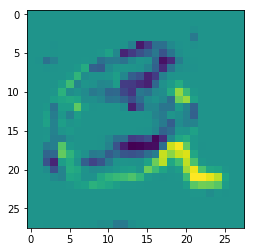

In [328]:
plt.figure(figsize=(4,4))
plt.imshow(aimg - oa1.reshape(28,28))

---
## 9. 결과 검증

각 100건의 정상과 비정상 이미지를 이용하여 Anobal loss를 비교해봅니다. 

우선 임의의 100개의 MNIST 데이터를 정상 이미지로 이용하겠습니다.

In [350]:
nimg_multi = X_train[:100].reshape(100,28,28)

In [351]:
%%time
z = np.random.uniform(0, 1, size=(100, 100))
intermidiate_model = feature_extractor(img_shape)

# ground truth
x = nimg_multi.reshape(100,28,28,1)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_normal = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 35.2 s, sys: 397 ms, total: 35.6 s
Wall time: 31 s


다음은 100개의 EMNIST 이미지를 입력으로 학습을 진행합니다.

In [358]:
aimg_multi = images[:100].reshape(100,28,28)/ 127.5 - 1.

In [359]:
%%time
z = np.random.uniform(0, 1, size=(100, 100))
intermidiate_model = feature_extractor(img_shape)

# ground truth
x = aimg_multi.reshape(100,28,28,1)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_abnormal = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 35.7 s, sys: 454 ms, total: 36.2 s
Wall time: 31.5 s


두 데이터에 대한 학습 진행과정을 비교해봅니다. 전체 epoch에 걸쳐서 이상 데이터의 경우 정상 데이터보다 학습 loss가 높은 것을 확인할 수 있습니다.

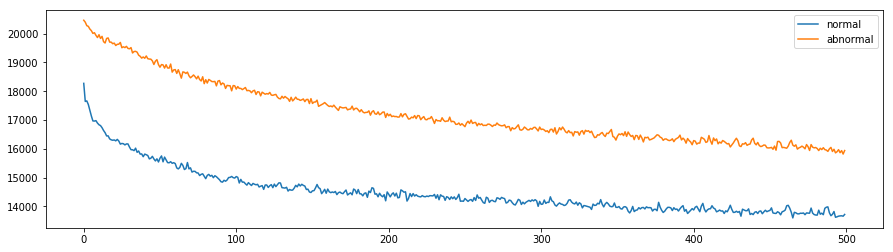

In [361]:
plt.plot(loss_normal.history['loss'])
plt.plot(loss_abnormal.history['loss'])
plt.legend(['normal','abnormal'])
plt.show()